In [3]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import RandomizedSearchCV



df = pd.read_csv(
    "bank-additional-full.csv",
    sep=';',
    quotechar='"',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  # Skips any problematic lines
)

print(df.columns)
print("Shape:", df.shape)
df.head()

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


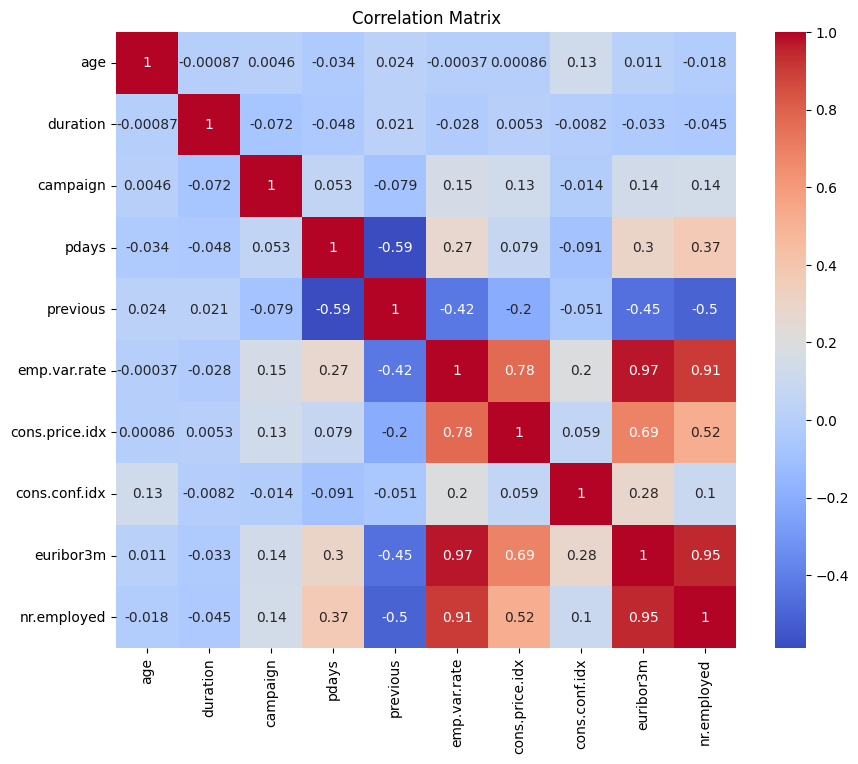

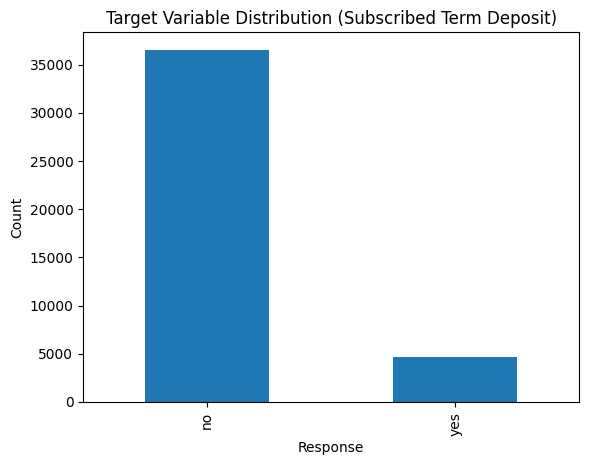

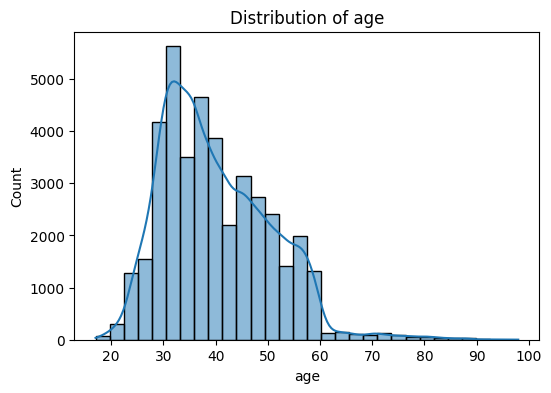

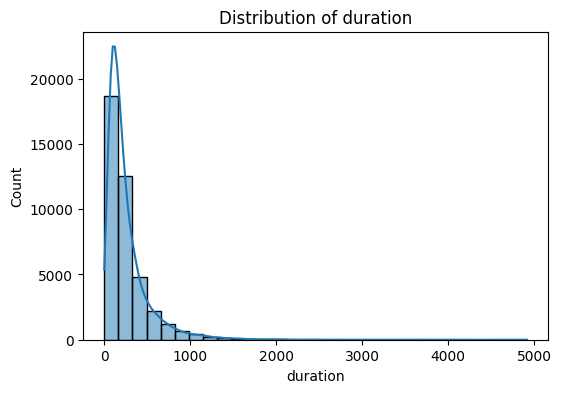

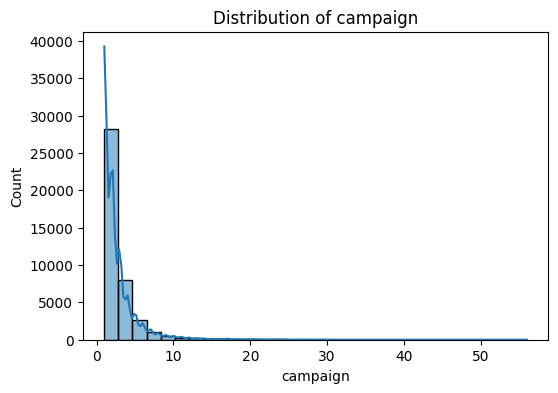

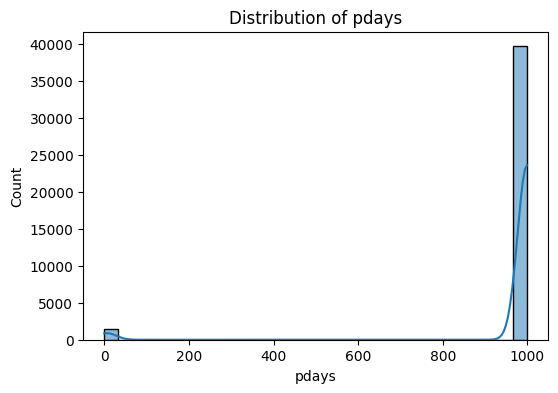

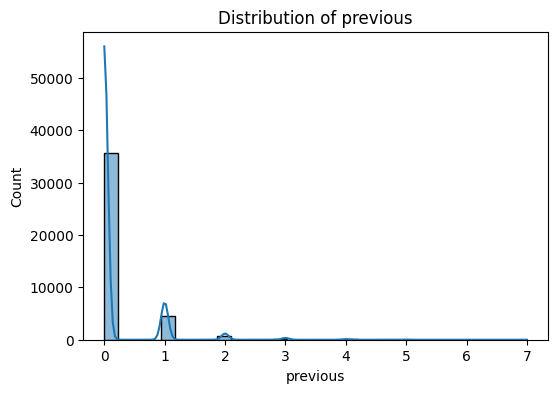

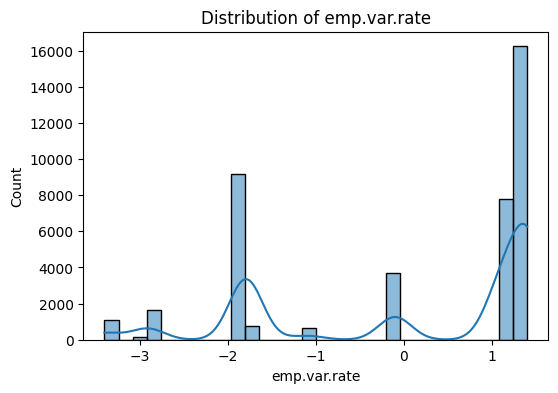

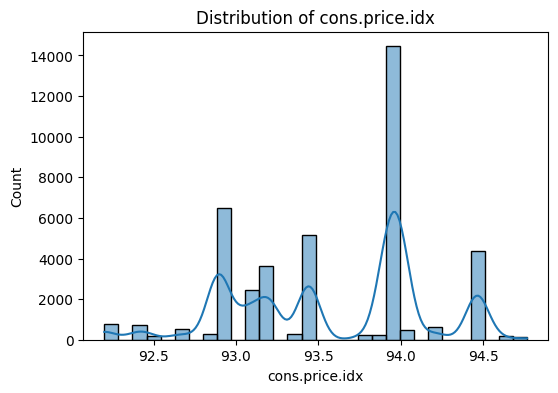

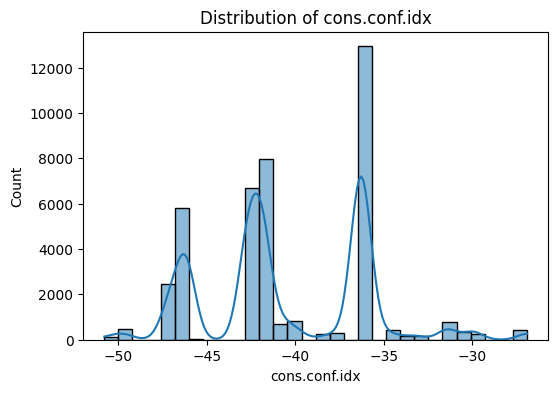

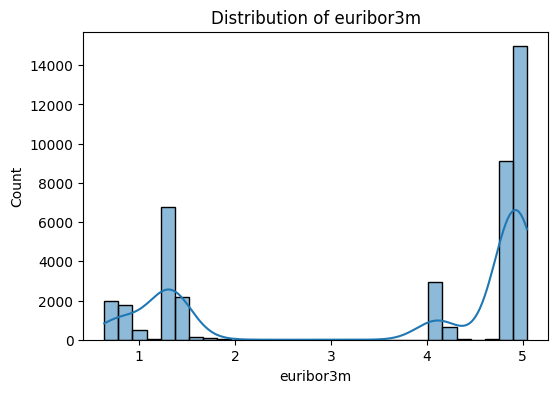

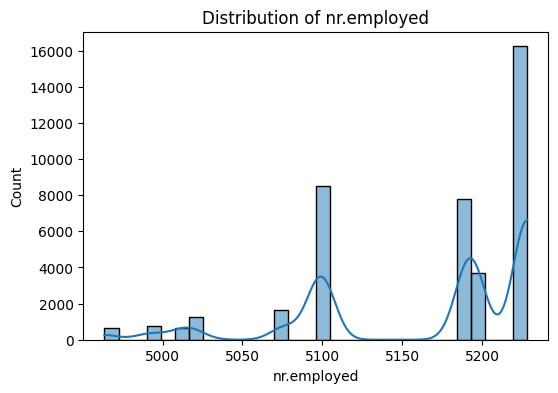


Class distribution:
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


In [7]:
# 1. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# 2. Correlation matrix for numeric variables
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 3. Distribution of the target variable
df['y'].value_counts().plot(kind='bar')
plt.title("Target Variable Distribution (Subscribed Term Deposit)")
plt.xlabel("Response")
plt.ylabel("Count")
plt.show()

# 4. Histograms for numerical features
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# 5. Class imbalance indicator
print("\nClass distribution:")
print(df['y'].value_counts(normalize=True))



Feature variances:
age               1.0
pdays             1.0
emp.var.rate      1.0
previous          1.0
nr.employed       1.0
cons.conf.idx     1.0
euribor3m         1.0
campaign          1.0
duration          1.0
cons.price.idx    1.0
dtype: float64


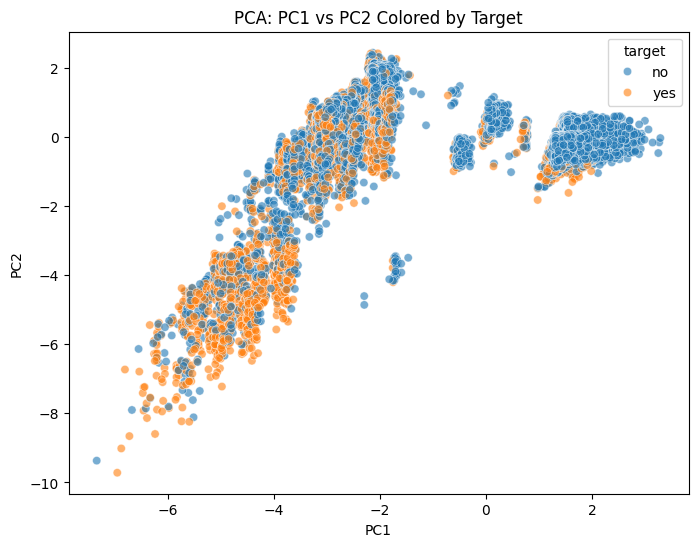

In [8]:
# Standardize numeric columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_cols])

# Check for low-variance features
variances = pd.Series(df_scaled.var(axis=0), index=numeric_cols)
print("\nFeature variances:")
print(variances.sort_values())

# PCA visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Add target for plotting
df_vis = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_vis['target'] = df['y'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="target", alpha=0.6)
plt.title("PCA: PC1 vs PC2 Colored by Target")
plt.show()

In [9]:
# ------------------
# Feature Engineering
# ------------------

# Log-transform skewed features
df['log_duration'] = np.log1p(df['duration'])
df['log_campaign'] = np.log1p(df['campaign'])
df['log_pdays'] = np.log1p(df['pdays'].replace(999, 0))

# Binary feature: was contacted previously
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)

# Interaction feature: contact + month
df['contact_month'] = df['contact'] + '_' + df['month']

# One-hot encode categorical variables
categorical_cols = df.select_dtypes(include='object').drop(columns='y').columns
ohe = OneHotEncoder(sparse_output=False, drop='first')
df_ohe = pd.DataFrame(ohe.fit_transform(df[categorical_cols]), columns=ohe.get_feature_names_out(categorical_cols))

# Merge encoded features and drop originals
df_final = pd.concat([df.drop(columns=categorical_cols), df_ohe], axis=1)

# Preview engineered dataset
print("\nShape after feature engineering:", df_final.shape)
df_final.head()


Shape after feature engineering: (41188, 77)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,contact_month_telephone_apr,contact_month_telephone_aug,contact_month_telephone_dec,contact_month_telephone_jul,contact_month_telephone_jun,contact_month_telephone_mar,contact_month_telephone_may,contact_month_telephone_nov,contact_month_telephone_oct,contact_month_telephone_sep
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
# ------------------
# Modeling with SMOTE
# ------------------

# Define features and target
X = df_final.drop(columns='y')
y = df['y'].map({'no': 0, 'yes': 1})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Logistic Regression (on SMOTE data)
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000)
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression with SMOTE Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Random Forest (on SMOTE data)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest with SMOTE Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression with SMOTE Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7310
           1       0.43      0.88      0.58       928

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.88      8238

Confusion Matrix:
[[6234 1076]
 [ 111  817]]

Random Forest with SMOTE Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7310
           1       0.64      0.58      0.61       928

    accuracy                           0.92      8238
   macro avg       0.80      0.77      0.78      8238
weighted avg       0.91      0.92      0.91      8238

Confusion Matrix:
[[7011  299]
 [ 388  540]]


In [11]:
# ------------------
# Hyperparameter Tuning - Random Forest
# ------------------

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV setup
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on SMOTE training data
rf_random.fit(X_train_sm, y_train_sm)

# Best model evaluation
y_pred_rf_best = rf_random.predict(X_test)
print("\nTuned Random Forest Report:")
print(classification_report(y_test, y_pred_rf_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tuned Random Forest Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7310
           1       0.62      0.69      0.66       928

    accuracy                           0.92      8238
   macro avg       0.79      0.82      0.80      8238
weighted avg       0.92      0.92      0.92      8238

Confusion Matrix:
[[6920  390]
 [ 285  643]]


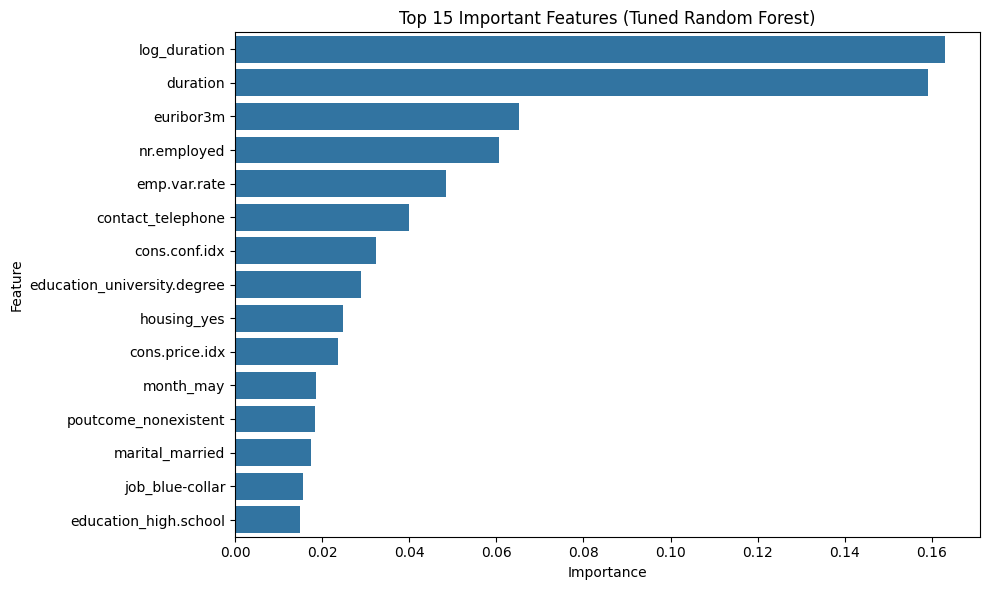

In [12]:
# ------------------
# Feature Importance
# ------------------

importances = rf_random.best_estimator_.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))
plt.title("Top 15 Important Features (Tuned Random Forest)")
plt.tight_layout()
plt.show()

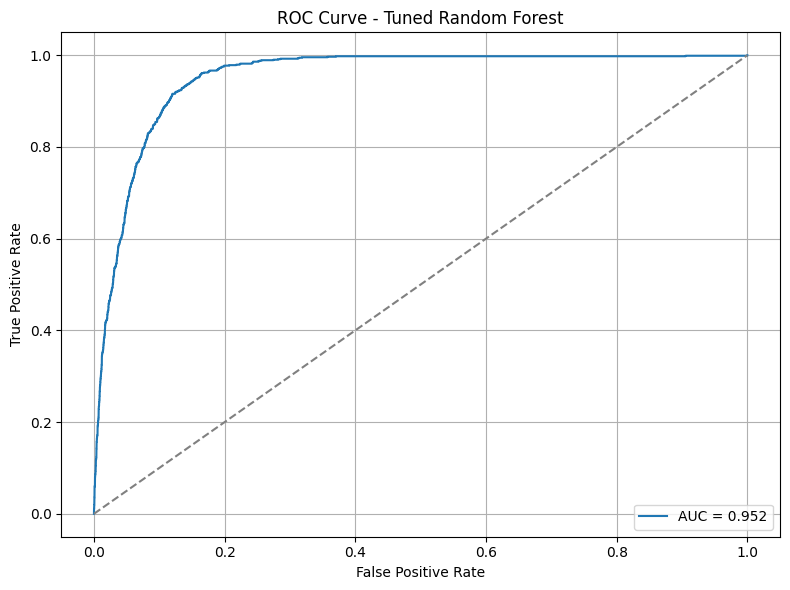

In [13]:
# ------------------
# ROC Curve and AUC
# ------------------

from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities
y_proba_rf_best = rf_random.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf_best)
auc_score = roc_auc_score(y_test, y_proba_rf_best)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# ------------------
# XGBoost Classifier
# ------------------

from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb_clf.predict(X_test)

print("\nXGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:59:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7310
           1       0.66      0.59      0.62       928

    accuracy                           0.92      8238
   macro avg       0.80      0.77      0.79      8238
weighted avg       0.92      0.92      0.92      8238

Confusion Matrix:
[[7028  282]
 [ 385  543]]


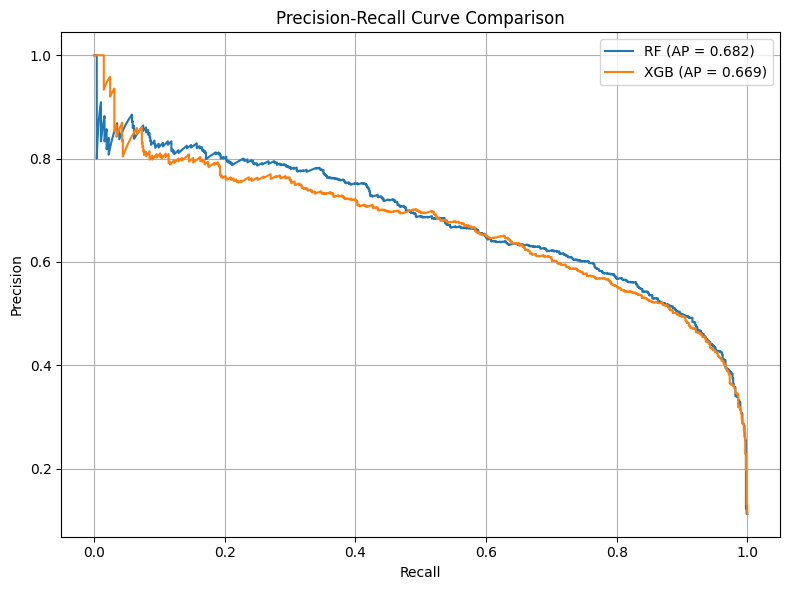

In [15]:
# ------------------
# Precision-Recall Curve Comparison
# ------------------

from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities for both models
y_scores_rf = rf_random.predict_proba(X_test)[:, 1]
y_scores_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Compute curves and AUC
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)
avg_precision_rf = average_precision_score(y_test, y_scores_rf)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_scores_xgb)
avg_precision_xgb = average_precision_score(y_test, y_scores_xgb)

# Plot both PR curves
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f"RF (AP = {avg_precision_rf:.3f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGB (AP = {avg_precision_xgb:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Model Comparison Table:
                   Model  Accuracy  Precision    Recall  F1 Score
1  Random Forest (Tuned)  0.918063   0.622459  0.692888  0.655788
2                XGBoost  0.919034   0.658182  0.585129  0.619509
0    Logistic Regression  0.855912   0.431590  0.880388  0.579227


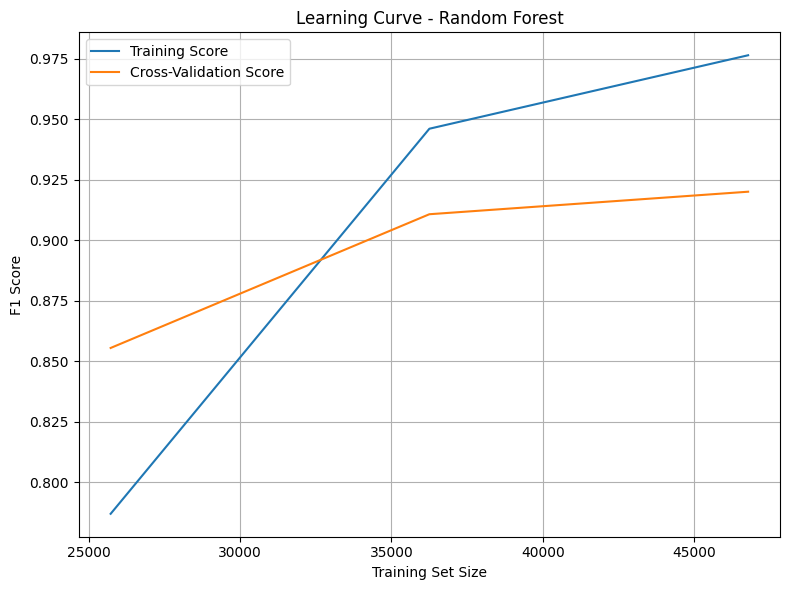

In [16]:
# ------------------
# Model Comparison Table
# ------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

logreg = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
logreg.fit(X_train_sm, y_train_sm)

models = {
    "Logistic Regression": logreg,
    "Random Forest (Tuned)": rf_random.best_estimator_,
    "XGBoost": xgb_clf
}

comparison_results = []

for name, model in models.items():
    preds = model.predict(X_test)
    comparison_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nModel Comparison Table:")
print(comparison_df.sort_values(by="F1 Score", ascending=False))

# ------------------
# Learning Curve - Random Forest
# ------------------

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_random.best_estimator_, X_train_sm, y_train_sm, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

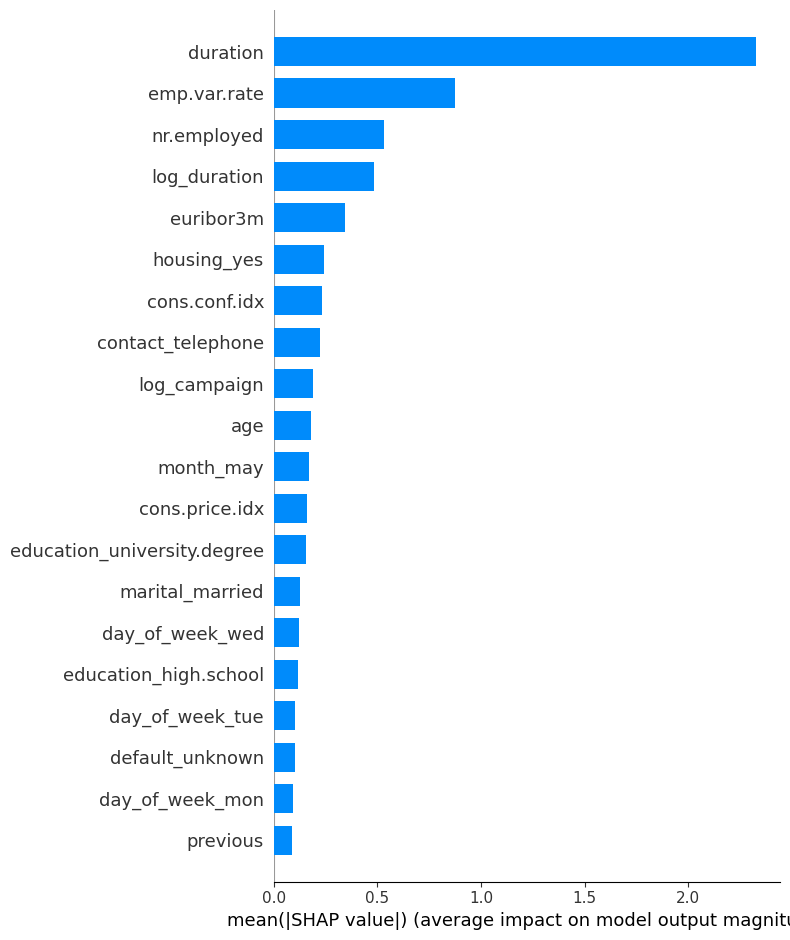

In [17]:
# ------------------
# SHAP Explainability for XGBoost
# ------------------

import shap
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)

# Summary plot for top features
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [18]:
# ------------------
# Ablation Study - Remove Duration Features
# ------------------

X_ablate = X.drop(columns=["duration", "log_duration"])
X_train_ablate, X_test_ablate, y_train_ablate, y_test_ablate = train_test_split(
    X_ablate, y, test_size=0.2, stratify=y, random_state=42
)

sm_ablate = SMOTE(random_state=42)
X_train_ablate_sm, y_train_ablate_sm = sm_ablate.fit_resample(X_train_ablate, y_train_ablate)

rf_ablate = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_ablate.fit(X_train_ablate_sm, y_train_ablate_sm)

y_pred_ablate = rf_ablate.predict(X_test_ablate)

print("\nRandom Forest without duration/log_duration:")
print(classification_report(y_test_ablate, y_pred_ablate))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ablate, y_pred_ablate))



Random Forest without duration/log_duration:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7310
           1       0.55      0.35      0.42       928

    accuracy                           0.89      8238
   macro avg       0.73      0.65      0.68      8238
weighted avg       0.88      0.89      0.88      8238

Confusion Matrix:
[[7046  264]
 [ 607  321]]


In [ ]:
# ------------------
# Ensemble Voting Classifier
# ------------------

from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ('rf', rf_random.best_estimator_),
        ('xgb', xgb_clf),
        ('lr', logreg)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble_clf.fit(X_train_sm, y_train_sm)
y_pred_ensemble = ensemble_clf.predict(X_test)

print("\nVoting Classifier Report:")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))

# ------------------
# Calibration Curve
# ------------------

from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, ensemble_clf.predict_proba(X_test)[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Ensemble')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve - Ensemble Classifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()